# Exercise 1: Linear Regression

### This notebook is executed automatically. Failing to meet any of the submission requirements will results in a 25 point fine or your submission not being graded at all. Kindly reminder: the homework assignments grade is 50% of the final grade. 

### Do not start the exercise until you fully understand the submission guidelines.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
1. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw1_123456789_987654321.ipynb` if you submitted in pairs and `hw1_123456789.ipynb` if you submitted the exercise alone.
1. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
1. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
1. Write your functions in this notebook only. **Do not create Python modules and import them**.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
1. Your code must run without errors. Make sure your `numpy` version is at least 1.15.4 and that you are using at least python 3.6. Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Load a dataset and perform basic data exploration using a powerful data science library called [pandas](https://pandas.pydata.org/pandas-docs/stable/).
1. Preprocess the data for linear regression.
1. Compute the cost and perform gradient descent in pure numpy in vectorized form.
1. Fit a linear regression model using a single feature.
1. Visualize your results using matplotlib.
1. Perform multivariate linear regression.
1. Pick the best features in the dataset.
1. Experiment with adaptive learning rates.

# I have read and understood the instructions:  ***313581654_316298876 ***

In [54]:
import numpy as np # used for scientific computing
import pandas as pd # used for data analysis and manipulation
import matplotlib.pyplot as plt # used for visualization and plotting


np.random.seed(42) 

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## Part 1: Data Preprocessing (10 Points)

For the following exercise, we will use a dataset containing housing prices in King County, USA. The dataset contains 5,000 observations with 18 features and a single target value - the house price. 

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [55]:
# Read comma separated data
df = pd.read_csv('data.csv') # Make sure this cell runs regardless of your absolute path.
# df stands for dataframe, which is the default format for datasets in pandas

### Data Exploration
A good practice in any data-oriented project is to first try and understand the data. Fortunately, pandas is built for that purpose. Start by looking at the top of the dataset using the `df.head()` command. This will be the first indication that you read your data properly, and that the headers are correct. Next, you can use `df.describe()` to show statistics on the data and check for trends and irregularities.

In [56]:
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,0,98074,47.6168,-122.045,1800,7503


In [57]:
df.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,5.000000e+03,5.000000e+03,5000.0000,5000.000000,5000.000000,5.000000e+03,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000
mean,4.630823e+09,5.394699e+05,3.3714,2.062150,2061.036800,1.615893e+04,1.432600,0.009400,0.243000,3.455000,7.595200,1753.151000,1966.660800,95.052800,98078.812600,47.559312,-122.215864,1976.84520,13451.164600
std,2.870890e+09,3.873115e+05,0.9104,0.773592,923.727509,4.600220e+04,0.510793,0.096506,0.774643,0.677692,1.166537,818.390844,28.286855,425.234932,54.126332,0.139521,0.141807,674.73601,26514.749009
min,1.000102e+06,7.500000e+04,0.0000,0.000000,380.000000,6.090000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,380.000000,1900.000000,0.000000,98001.000000,47.155900,-122.514000,620.00000,660.000000
25%,2.154075e+09,3.179062e+05,3.0000,1.500000,1410.000000,5.400000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1949.000000,0.000000,98033.000000,47.463675,-122.329000,1490.00000,5391.500000
50%,4.022900e+09,4.490000e+05,3.0000,2.000000,1890.000000,7.875000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1530.000000,1968.000000,0.000000,98070.000000,47.572850,-122.235000,1820.00000,7800.000000
75%,7.345078e+09,6.500000e+05,4.0000,2.500000,2500.000000,1.123400e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2130.000000,1990.000000,0.000000,98118.000000,47.679200,-122.129000,2340.00000,10469.250000
max,9.842300e+09,7.060000e+06,9.0000,6.750000,10040.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,7680.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,5790.00000,434728.000000


We will start with one variable linear regression by extracting the target column and the `sqft_living` variable from the dataset. We use pandas and select both columns as separate variables and transform them into a numpy array.

In [58]:
X = df['sqft_living'].values
y = df['price'].values

## Preprocessing

As the number of features grows, calculating gradients gets computationally expensive. We can speed this up by normalizing the input data to ensure all values are within the same range. This is especially important for datasets with high standard deviations or differences in the ranges of the attributes. Use [mean normalization](https://en.wikipedia.org/wiki/Feature_scaling) for the fearures (`X`) and the true labels (`y`).

Implement the cost function `preprocess`.

In [59]:
def preprocess(X: np.ndarray, y: np.ndarray) -> (np.ndarray, np.ndarray):
    """
    Perform mean normalization on the features and true labels.

    Input:
    - X: Inputs (n features over m instances).
    - y: True labels.

    Returns a two vales:
    - X: The mean normalized inputs.
    - y: The mean normalized labels.
    """
    X = X.copy()
    y = y.copy()

    ###########################################################################
    # TODO: Implement the normalization function.                             #
    ###########################################################################
    # Supposed to be (x - avg(x)) / (max(x) - min(x))? --> In the piazza said to do as below.

    X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    y = (y - np.mean(y, axis=0)) / np.std(y, axis=0)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return X, y

In [60]:
X, y = preprocess(X, y)

We will split the data into two datasets: 
1. The training dataset will contain 80% of the data and will always be used for model training.
2. The validation dataset will contain the remaining 20% of the data and will be used for model evaluation. For example, we will pick the best alpha and the best features using the validation dataset, while still training the model using the training dataset.

In [61]:
# training and validation split
np.random.seed(42)
indices = np.random.permutation(X.shape[0])
idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_val = X[idx_train], X[idx_val]
y_train, y_val = y[idx_train], y[idx_val]

## Data Visualization
Another useful tool is data visualization. Since this problem has only two parameters, it is possible to create a two-dimensional scatter plot to visualize the data. Note that many real-world datasets are highly dimensional and cannot be visualized naively. We will be using `matplotlib` for all data visualization purposes since it offers a wide range of visualization tools and is easy to use.

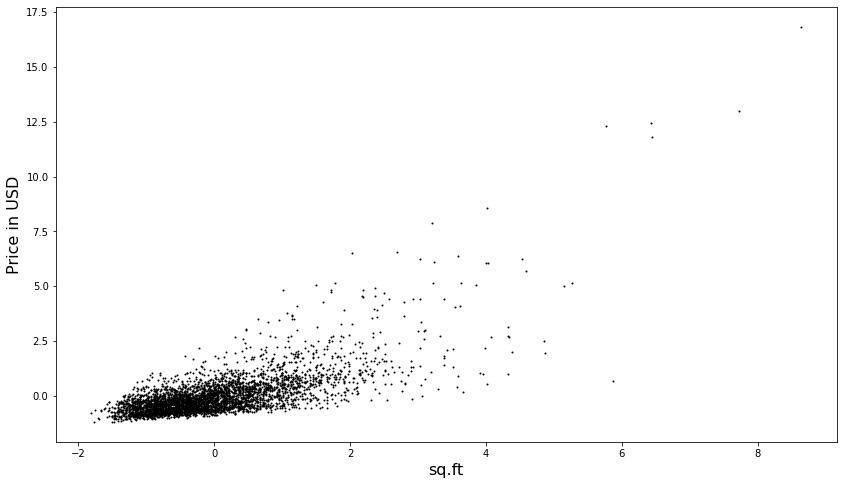

In [62]:
plt.plot(X_train, y_train, 'ro', ms=1, mec='k') # the parameters control the size, shape and color of the scatter plot
plt.ylabel('Price in USD', fontsize=16)
plt.xlabel('sq.ft', fontsize=16)
plt.show()

## Bias Trick

Make sure that `X` takes into consideration the bias $\theta_0$ in the linear model. Hint, recall that the predications of our linear model are of the form:

$$
\hat{y} = h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1
$$

Add columns of ones as the zeroth column of the features (do this for both the training and validation sets).

In [63]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
ones = np.ones((X_train.shape[0], 1))
X_train = X_train.reshape((X_train.shape[0], 1))
X_train = np.hstack((ones, X_train))

ones = np.ones((X_val.shape[0], 1))
X_val = X_val.reshape((X_val.shape[0], 1))
X_val = np.hstack((ones, X_val))
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

## Part 2: Single Variable Linear Regression (40 Points)
Simple linear regression is a linear regression model with a single explanatory varaible and a single target value. 

$$
\hat{y} = h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1
$$

## Gradient Descent 

Our task is to find the best possible linear line that explains all the points in our dataset. We start by guessing initial values for the linear regression parameters $\theta$ and updating the values using gradient descent. 

The objective of linear regression is to minimize the cost function $J$:

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{n}(h_\theta(x^{(i)})-y^{(i)})^2
$$

where the hypothesis (model) $h_\theta(x)$ is given by a **linear** model:

$$
h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1
$$

$\theta_j$ are parameters of your model. and by changing those values accordingly you will be able to lower the cost function $J(\theta)$. One way to accopmlish this is to use gradient descent:

$$
\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
$$

In linear regresion, we know that with each step of gradient descent, the parameters $\theta_j$ get closer to the optimal values that will achieve the lowest cost $J(\theta)$.

Implement the cost function `compute_cost`. (10 points)

In [64]:
def compute_cost(X: np.ndarray, y: np.ndarray, theta: np.ndarray) -> float:
    """
    Computes the average squared difference between an obserbation's actual and
    predicted values for linear regression.  

    Input:
    - X: inputs  (n features over m instances).
    - y: true labels (1 value over m instances).
    - theta: the parameters (weights) of the model being learned.

    Returns a single value:
    - J: the cost associated with the current set of parameters (single number).
    """
    
    J = 0  # Use J for the cost.
    ###########################################################################
    # TODO: Implement the MSE cost function.                                  #
    ###########################################################################
    J = np.sum(np.power(np.dot(X, theta) - y, 2)) / (2 * y.shape[0])
    # J = np.sum(np.power(np.dot(X, theta) - y, 2)) / (2 * y.shape[0])
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return J

In [65]:
theta = np.array([-1, 2])
J = compute_cost(X=X_train, y=y_train, theta=theta)
J

1.6003214548835494

Implement the gradient descent function `gradient_descent`. (10 points)

In [66]:
def gradient_descent(X: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha: float, num_iters: int) -> (np.ndarray, np.ndarray):
    """
    Learn the parameters of the model using gradient descent using 
    the *training set*. Gradient descent is an optimization algorithm 
    used to minimize some (loss) function by iteratively moving in 
    the direction of steepest descent as defined by the negative of 
    the gradient. We use gradient descent to update the parameters
    (weights) of our model.

    Input:
    - X: Inputs  (n features over m instances).
    - y: True labels (1 value over m instances).
    - theta: The parameters (weights) of the model being learned.
    - alpha: The learning rate of your model.
    - num_iters: The number of updates performed.

    Returns two values:
    - theta: The learned parameters of your model.
    - J_history: the loss value for every iteration.
    """
    X = X.copy()
    y = y.copy()
    theta = theta.copy() # avoid changing the original thetas

    J_history = [] # Use a python list to save cost in every iteration
    ###########################################################################
    # TODO: Implement the gradient descent optimization algorithm.            #
    ###########################################################################
    m = y.shape[0]
    for i in range(num_iters):
        theta = theta - (alpha / m) * np.matmul(X.T, np.matmul(X, theta.T) - y)
        J_history.append(compute_cost(X=X, y=y, theta=theta))
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return theta, np.array(J_history)

In [67]:
np.random.seed(42)
theta = np.random.random(size=2)
iterations = 40000
alpha = 0.1
theta, J_history = gradient_descent(X=X_train ,y=y_train, theta=theta, alpha=alpha, num_iters=iterations)

You can evaluate the learning process by monitoring the loss as training progress. In the following graph, we visualize the loss as a function of the iterations. This is possible since we are saving the loss value at every iteration in the `J_history` array. This visualization might help you find problems with your code. Notice that since the network converges quickly, we are using logarithmic scale for the number of iterations. 

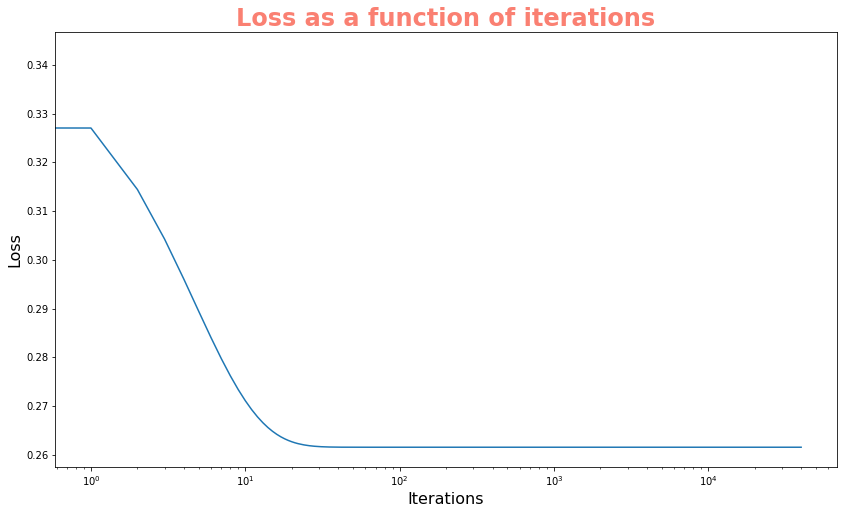

In [68]:
plt.plot(np.arange(iterations), J_history)
plt.xscale('log')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss as a function of iterations', fontsize=24, fontweight='bold', color='salmon')
plt.show()

Implement the pseudo-inverse function `pinv`. **Do not use `np.linalg.pinv`**, instead use only direct matrix multiplication as you saw in class (you can calculate the inverse of a matrix using `np.linalg.inv`). (10 points)

In [69]:
def pinv(X: np.ndarray, y: np.ndarray) -> np.ndarray:
    """
    Calculate the optimal values of the parameters using the pseudoinverse
    approach as you saw in class using the *training set*.

    Input:
    - X: Inputs  (n features over m instances).
    - y: True labels (1 value over m instances).

    Returns two values:
    - theta: The optimal parameters of your model.

    ########## DO NOT USE np.linalg.pinv ##############
    """
    X = X.copy()
    y = y.copy()

    pinv_theta = []
    ###########################################################################
    # TODO: Implement the pseudoinverse algorithm.                            #
    ###########################################################################
    pinv_x = np.matmul(np.linalg.inv(np.matmul(X.T, X)), X.T)
    pinv_theta = np.matmul(pinv_x, y)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return pinv_theta

In [70]:
theta_pinv = pinv(X_train ,y_train)
J_pinv = compute_cost(X_train, y_train, theta_pinv)

We can add the loss value for the theta calculated using the psuedo-inverse to our graph. This is another sanity check as the loss of our model should converge to the psuedo-inverse loss.

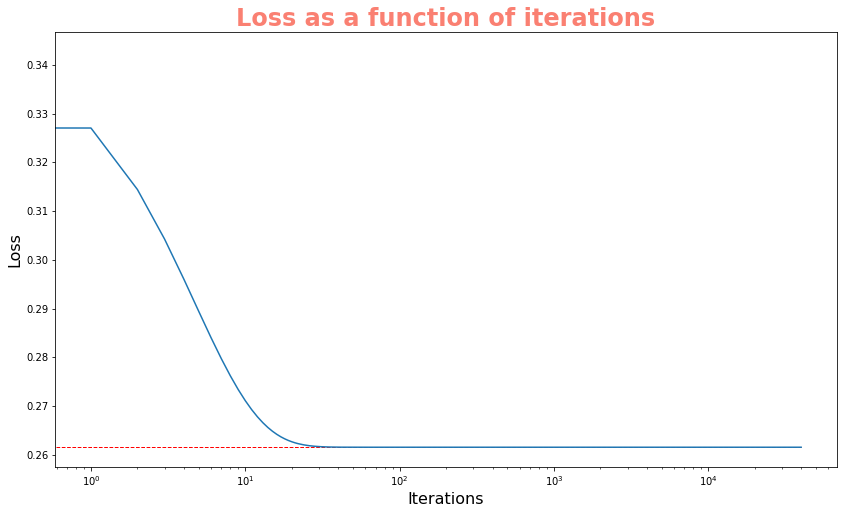

In [71]:
plt.plot(np.arange(iterations), J_history)
plt.xscale('log')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss as a function of iterations', fontsize=24, fontweight='bold', color='salmon')
plt.hlines(y=J_pinv, xmin=0, xmax=len(J_history), color='r', linewidth=1, linestyle='dashed')
plt.show()

We can use a better approach for the implementation of `gradient_descent`. Instead of performing 40,000 iterations, we wish to stop when the improvement of the loss value is smaller than `1e-8` from one iteration to the next. Implement the function `efficient_gradient_descent`. (5 points)

In [72]:
def efficient_gradient_descent(X: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha: float, num_iters: int) -> (np.ndarray, np.ndarray):
    """
    Learn the parameters of your model using the *training set*, but stop 
    the learning process once the improvement of the loss value is smaller 
    than 1e-8. This function is very similar to the gradient descent 
    function you already implemented.

    Input:
    - X: Inputs  (n features over m instances).
    - y: True labels (1 value over m instances).
    - theta: The parameters (weights) of the model being learned.
    - alpha: The learning rate of your model.
    - num_iters: The number of updates performed.

    Returns two values:
    - theta: The learned parameters of your model.
    - J_history: the loss value for every iteration.
    """
    X = X.copy()
    y = y.copy()

    J_history = [] # Use a python list to save cost in every iteration
    theta = theta.copy() # avoid changing the original thetas
    ###########################################################################
    # TODO: Implement the gradient descent optimization algorithm.            #
    ###########################################################################
    m = y.shape[0]
    for i in range(num_iters):
        theta = theta - (alpha / m) * np.matmul(X.T, np.matmul(X, theta.T) - y)
        J_history.append(compute_cost(X=X, y=y, theta=theta))

        if i > 0 and J_history[i-1] - J_history[i]  < 1e-8:
            break
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return theta, np.array(J_history)

The learning rate is another factor that determines the performance of our model in terms of speed and accuracy. Complete the function `find_best_alpha`. Make sure you use the training dataset to learn the parameters (thetas) and use those parameters with the validation dataset to compute the cost.

In [73]:
def find_best_alpha(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, iterations: int) -> dict:
    """
    Iterate over provided values of alpha and train a model using the 
    *training* dataset. maintain a python dictionary with alpha as the 
    key and the loss on the *validation* set as the value.

    Input:
    - X_train, y_train, X_val, y_val: the training and validation data
    - iterations: maximum number of iterations

    Returns:
    - alpha_dict: A python dictionary - {key (alpha) : value (validation loss)}
    """
    
    X_train = X_train.copy()
    y_train = y_train.copy()
    X_val = X_val.copy()
    y_val = y_val.copy()

    alphas = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 2, 3]
    alpha_dict = {}
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    np.random.seed(42)
    theta_rnd = np.random.random(size=X_train.shape[1])
    for alpha in alphas:
        theta, _ = efficient_gradient_descent(X=X_train, y=y_train, theta=theta_rnd, alpha=alpha, num_iters=iterations)
        alpha_dict[alpha] = compute_cost(X=X_val, y=y_val, theta=theta)   
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return alpha_dict

In [74]:
alpha_dict = find_best_alpha(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, iterations=40000)

Obtain the best learning rate from the dictionary `alpha_dict`. This can be done in a single line using built-in functions.

In [75]:
best_alpha = None
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
best_alpha = min(alpha_dict, key=alpha_dict.get)
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################
print(best_alpha)

1


Pick the best three alpha values you just calculated and provide **one** graph with three lines indicating the training loss as a function of iterations (Use 10,000 iterations). Note you are required to provide general code for this purpose (no hard-coding). Make sure the visualization is clear and informative. (5 points)

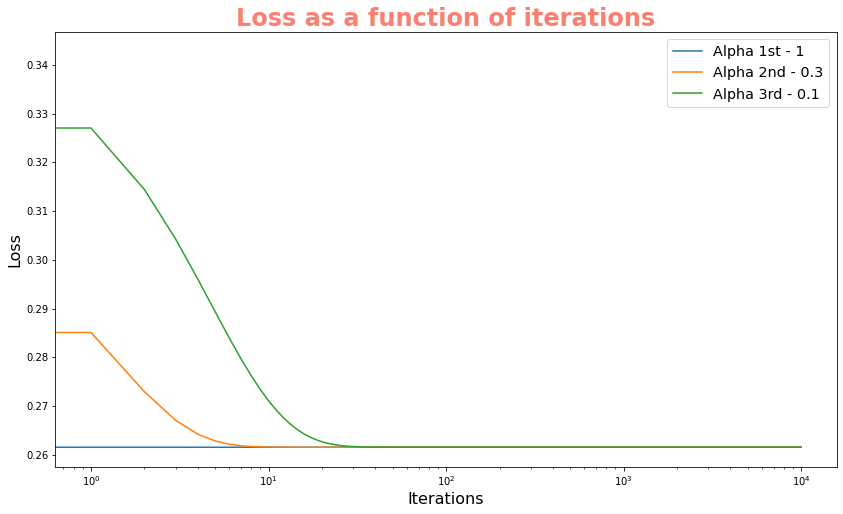

In [76]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
_d = alpha_dict.copy();
alpha_1st = min(_d, key=alpha_dict.get)
del _d[alpha_1st]
alpha_2nd = min(_d, key=alpha_dict.get)
del _d[alpha_2nd]
alpha_3rd = min(_d, key=alpha_dict.get)
del _d[alpha_3rd]

np.random.seed(42)
theta_rnd = np.random.random(size=X_train.shape[1])

iterations = 10000
_, J_history = gradient_descent(X=X_train ,y=y_train, theta=theta_rnd, alpha=alpha_1st, num_iters=iterations)
_, J_history2 = gradient_descent(X=X_train ,y=y_train, theta=theta_rnd, alpha=alpha_2nd, num_iters=iterations)
_, J_history3 = gradient_descent(X=X_train ,y=y_train, theta=theta_rnd, alpha=alpha_3rd, num_iters=iterations)

plt.plot(np.arange(len(J_history)), J_history, label=f'Alpha 1st - {alpha_1st}')
plt.plot(np.arange(len(J_history2)), J_history2, label=f'Alpha 2nd - {alpha_2nd}')
plt.plot(np.arange(len(J_history3)), J_history3, label=f'Alpha 3rd - {alpha_3rd}')

plt.legend(fontsize='x-large')

plt.xscale('log')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)

plt.title('Loss as a function of iterations', fontsize=24, fontweight='bold', color='salmon')
plt.show()
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

This is yet another sanity check. This function plots the regression lines of your model and the model based on the pseudoinverse calculation. Both models should exhibit the same trend through the data. 

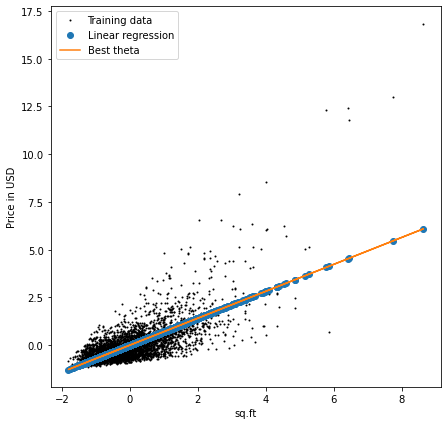

In [77]:
plt.figure(figsize=(7, 7))
plt.plot(X_train[:,1], y_train, 'ro', ms=1, mec='k')
plt.ylabel('Price in USD')
plt.xlabel('sq.ft')
plt.plot(X_train[:, 1], np.dot(X_train, theta), 'o')
plt.plot(X_train[:, 1], np.dot(X_train, theta_pinv), '-')

plt.legend(['Training data', 'Linear regression', 'Best theta']);

## Part 2: Multivariate Linear Regression (30 points)

In most cases, you will deal with databases that have more than one feature. It can be as little as two features and up to thousands of features. In those cases, we use a multiple linear regression model. The regression equation is almost the same as the simple linear regression equation:

$$
\hat{y} = h_\theta(\vec{x}) = \theta^T \vec{x} = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n
$$


If you wrote vectorized code, this part should be straightforward. If your code is not vectorized, you should go back and edit your functions such that they support both multivariate and single variable regression. **Your code should not check the dimensionality of the input before running**.

In [78]:
# Read comma separated data
df = pd.read_csv('data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,1987,0,98074,47.6168,-122.045,1800,7503


## Preprocessing

Like in the single variable case, we need to create a numpy array from the dataframe. Before doing so, we should notice that some of the features are clearly irrelevant.

In [79]:
X = df.drop(columns=['price', 'id', 'date']).values
y = df['price'].values

Use the **same** `preprocess` function you implemented previously. Notice that proper vectorized implementation should work regardless of the dimensionality of the input. You might want to check that your code in the previous parts still works.

In [80]:
# preprocessing
X, y = preprocess(X, y)

In [81]:
# training and validation split
np.random.seed(42)
indices = np.random.permutation(X.shape[0])
idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_val = X[idx_train,:], X[idx_val,:]
y_train, y_val = y[idx_train], y[idx_val]

Using 3D visualization, we can still observe trends in the data. Visualizing additional dimensions requires advanced techniques we will learn later in the course.

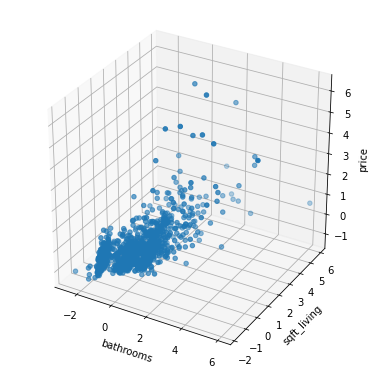

In [82]:
%matplotlib inline
import mpl_toolkits.mplot3d.axes3d as p3
fig = plt.figure(figsize=(5,5))
ax = p3.Axes3D(fig)
xx = X_train[:, 1][:1000]
yy = X_train[:, 2][:1000]
zz = y_train[:1000]
ax.scatter(xx, yy, zz, marker='o')
ax.set_xlabel('bathrooms')
ax.set_ylabel('sqft_living')
ax.set_zlabel('price')
plt.show()

Use the bias trick again (add a column of ones as the zeroth column in the both the training and validation datasets).

In [83]:
###########################################################################
#                            START OF YOUR CODE                           #
###########################################################################
ones = np.ones((X_train.shape[0], 1))
X_train = np.hstack((ones, X_train))

ones = np.ones((X_val.shape[0], 1))
X_val = np.hstack((ones, X_val))
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################

Make sure the functions `compute_cost` (10 points), `gradient_descent` (15 points), and `pinv` (5 points) work on the multi-dimensional dataset. If you make any changes, make sure your code still works on the single variable regression model. 

In [84]:
shape = X_train.shape[1]
theta = np.ones(shape)
J = compute_cost(X=X_train, y=y_train, theta=theta)

In [85]:
alpha_dict = find_best_alpha(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, iterations=40000)
best_alpha = min(alpha_dict, key=alpha_dict.get)

In [86]:
np.random.seed(42)
shape = X_train.shape[1]
theta = np.random.random(shape)
iterations = 40000
theta, J_history = gradient_descent(X=X_train ,y=y_train, theta=theta, alpha=best_alpha, num_iters=iterations)

In [87]:
theta_pinv = pinv(X=X_train ,y=y_train)
J_pinv = compute_cost(X=X_train, y=y_train, theta=theta_pinv)

We can use visualization to make sure the code works well. Notice we use logarithmic scale for the number of iterations, since gradient descent converges after ~500 iterations.

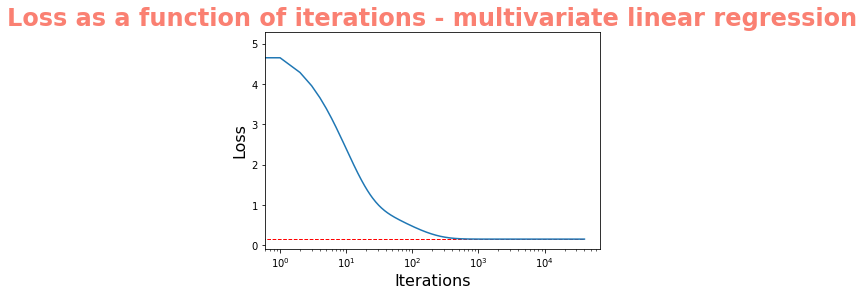

In [88]:
plt.plot(np.arange(iterations), J_history)
plt.xscale('log')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss as a function of iterations - multivariate linear regression', fontsize=24, fontweight='bold', color='salmon')
plt.hlines(y = J_pinv, xmin = 0, xmax = len(J_history), color='r',
           linewidth = 1, linestyle = 'dashed')
plt.show()

## Part 3: Find best features for regression (10 points)

Adding additional features to our regression model makes it more complicated but does not necessarily improves performance.
Use forward and backward selection and find 4 features that best minimizes the loss. First, we will reload the dataset as a dataframe in order to access the feature names.

In [89]:
df = pd.read_csv('data.csv')

all_features = df.drop(columns=['id', 'date'])
all_features = (all_features - all_features.mean(axis=0)) / all_features.std(axis=0)

y = all_features['price'].values

all_features.drop(columns=['price'], inplace=True)

all_features_train = all_features.iloc[idx_train]
all_features_val = all_features.iloc[idx_val]

y_train = y[idx_train]
y_val = y[idx_val]

### Forward Feature Selection

Complete the function `forward_selection`. Train the model using a single feature at a time, and choose the best feature using the validation dataset. Next, check which feature performs best when added to the feature you previously chose. Repeat this process until you reach 4 features + bias. You are free to use any arguments you need.

In [90]:
def forward_selection(all_features_train: pd.DataFrame, all_features_val: pd.DataFrame, y_train: np.ndarray, y_val: np.ndarray) -> list:
    """
    Train the model using the training set using a single feature.
    Choose the best feature according to the validation set. Next,
    check which feature performs best when added to the feature
    you previously chose. Repeat this process until you reach 4
    features and the bias. Don't forget the bias trick.

    Returns:
    - The names of the best features using forward selection.
    """
    np.random.seed(42)
    best_features = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    all_features_train = all_features_train.copy()
    all_features_val = all_features_val.copy()
    y_train = y_train.copy()
    y_val = y_val.copy()

    best_features = []

    for feature_k in range(4):
        feature_name = ''
        feature_J = np.inf
        for feature in all_features_train.columns:
            if best_features.__contains__(feature):
                continue

            X_train = all_features_train[best_features + [feature]].values
            X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

            X_val = all_features_val[best_features + [feature]].values
            X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))

            theta = pinv(X=X_train, y=y_train)
            feature_cost = compute_cost(X=X_val, y=y_val, theta=theta)

            if feature_J > feature_cost:
                feature_name = feature
                feature_J = feature_cost

        print(f'{feature_k + 1} - ', feature_name)
        best_features.append(feature_name)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return best_features

In [91]:
forward_selection(all_features_train=all_features_train, all_features_val=all_features_val, y_train=y_train, y_val=y_val)

1 -  sqft_living
2 -  lat
3 -  waterfront
4 -  grade


['sqft_living', 'lat', 'waterfront', 'grade']

### Backward Feature Selection

Complete the function `backward_selection`. Train the model with all but one of the features at a time and remove the worst feature (the feature that its absence yields the best loss value using the validation dataset). Next, remove an additional feature along with the feature you previously removed. Repeat this process until you reach 4 features + bias. You are free to use any arguments you need.

In [92]:
def backward_selection(all_features_train: pd.DataFrame, all_features_val: pd.DataFrame, y_train: np.ndarray, y_val: np.ndarray) -> list:
    """
    Train the model using the training set using all but one of the
    features at a time. Remove the worst feature according to the
    validation set. Next, remove an additional feature along with the
    feature you previously removed. Repeat this process until you
    reach 4 features and the bias. Don't forget the bias trick.

    Returns:
    - The names of the best features using backward selection.
    """
    np.random.seed(42)
    best_features = None
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################

    all_features_train = all_features_train.copy()
    all_features_val = all_features_val.copy()
    y_train = y_train.copy()
    y_val = y_val.copy()
    
    features_cols = all_features.columns.tolist()

    remove_features = []

    while True:
        feature_name = ''
        feature_J = np.inf
        for feature in all_features.columns:
            if remove_features.__contains__(feature):
                continue

            features = features_cols.copy()

            if features.__contains__(feature):
                features.remove(feature)

            for r in remove_features:
                if features.__contains__(r):
                    features.remove(r)

            X_train = all_features_train[features].values
            X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))

            X_val = all_features_val[features].values
            X_val = np.hstack((np.ones((X_val.shape[0], 1)), X_val))

            theta = pinv(X=X_train, y=y_train)
            feature_cost = compute_cost(X=X_val, y=y_val, theta=theta)

            if feature_J > feature_cost:
                feature_name = feature
                feature_J = feature_cost

        print(f'Removing {feature_name}')
        remove_features.append(feature_name)

        if len(features_cols) - len(remove_features) == 4:
            break

    best_features = features_cols.copy()

    for r in remove_features:
        if r in best_features:
            best_features.remove(r)

    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return best_features

In [93]:
backward_selection(all_features_train=all_features_train, all_features_val=all_features_val, y_train=y_train, y_val=y_val)

Removing sqft_living15
Removing sqft_lot
Removing sqft_lot15
Removing floors
Removing yr_renovated
Removing condition
Removing long
Removing sqft_above
Removing zipcode
Removing view
Removing bathrooms
Removing bedrooms
Removing yr_built


['sqft_living', 'waterfront', 'grade', 'lat']

Give an explanations to the results. Do they make sense?

We found that the forward and backward outputs are the same and the features are: sqft_living, waterfront, grade, lat

The results make sense because the way we calculating the cost doesn't matter if we calculate forward or backward.

In the forward (first iteration) approach, we calculating $J_1$ to $J_17$ and then taking the minimum.

In the backward (first iteration) approach, we calculated all features but one (for example without the first one we get $J_2 + J_3 + \dots + J_{17}$) and removing the feature with the highest cost.

In the end, the results should be the same, it's much faster to do forward because we need only 4 features but if we needed to calculate 15 features backward approach is preferred.

On the logical side of our sense, features like size, water-front, location, and grade are very much reasonable to determine the house pricing.

## Part 4: Adaptive Learning Rate (10 points)

So far, we kept the learning rate alpha constant during training. However, changing alpha during training might improve convergence in terms of the global minimum found and running time. Implement the adaptive learning rate method based on the gradient descent algorithm above. 

**Your task is to find proper hyper-parameter values for the adaptive technique and compare this technique to the constant learning rate. Use clear visualizations of the validation loss and the learning rate as a function of the iteration**. 

Time based decay: this method reduces the learning rate every iteration according to the following formula:

$$\alpha = \frac{\alpha_0}{1 + D \cdot t}$$

Where $\alpha_0$ is the original learning rate, $D$ is a decay factor and $t$ is the current iteration.

In [94]:
def efficient_gradient_descent_with_decay(X: np.ndarray, y: np.ndarray, theta: np.ndarray, alpha_0: float, decay: float, num_iters: int) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Learn the parameters of your model using the *training set*, but stop 
    the learning process once the improvement of the loss value is smaller 
    than 1e-8. This function is very similar to the gradient descent 
    function you already implemented.

    Input:
    - X: Inputs  (n features over m instances).
    - y: True labels (1 value over m instances).
    - theta: The parameters (weights) of the model being learned.
    - alpha: The learning rate of your model.
    - num_iters: The number of updates performed.

    Returns two values:
    - theta: The learned parameters of your model.
    - J_history: the loss value for every iteration.
    """
    X = X.copy()
    y = y.copy()

    J_history = [] # Use a python list to save cost in every iteration
    alpha_history = []
    theta = theta.copy() # avoid changing the original thetas
    ###########################################################################
    # TODO: Implement the gradient descent optimization algorithm.            #
    ###########################################################################
    m = y.shape[0]
    for i in range(num_iters):
        alpha = alpha_0 / (1 + decay * i)
        alpha_history.append(alpha)
        J_history.append(compute_cost(X=X, y=y, theta=theta))
        theta = theta - (alpha / m) * np.matmul(X.T, np.matmul(X, theta.T) - y)

        if i > 0 and J_history[i-1] - J_history[i]  < 1e-8:
            break
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return theta, np.array(J_history), np.array(alpha_history)

In [95]:
def find_best_decay(X_train: np.ndarray, y_train: np.ndarray, X_val: np.ndarray, y_val: np.ndarray, iterations: int) -> dict:
    """
    Iterate over provided values of alpha and train a model using the 
    *training* dataset. maintain a python dictionary with alpha as the 
    key and the loss on the *validation* set as the value.

    Input:
    - X_train, y_train, X_val, y_val: the training and validation data
    - iterations: maximum number of iterations

    Returns:
    - decays_dict: A python dictionary - {key (decay) : value (validation loss)}
    """
    
    X_train = X_train.copy()
    y_train = y_train.copy()
    X_val = X_val.copy()
    y_val = y_val.copy()
    
    alphas = [1, 0.5, 0.1, 0.05, 0.01]
    decays = [0.1 / np.power(10, x) for x in range(10)] + [0, 1]
    res_dict = {}
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    np.random.seed(42)
    theta_rnd = np.random.random(size=X_train.shape[1])
    for alpha in alphas:
        for decay in decays:
            theta, J_history, alpha_history = efficient_gradient_descent_with_decay(X=X_train ,y=y_train, theta=theta_rnd, alpha_0=alpha, decay=decay, num_iters=iterations)
            res_dict.update({f'{alpha}_{decay}': compute_cost(X=X_val, y=y_val, theta=theta)})
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return res_dict

In [96]:
res_dict = find_best_decay(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val, iterations=40000)

In [97]:
min(res_dict, key=res_dict.get)

'0.1_0.01'

Alpha = 0.1

Decay = 0.01

In [98]:
np.random.seed(42)
theta_rnd = np.random.random(size=X_train.shape[1])
theta, J_history, alpha_history = efficient_gradient_descent_with_decay(X=X_train ,y=y_train, theta=theta_rnd, alpha_0=0.1, decay=0.01, num_iters=40000)

In [99]:
min(J_history)

0.15282859200536042

In [100]:
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
iter = np.arange(len(J_history))

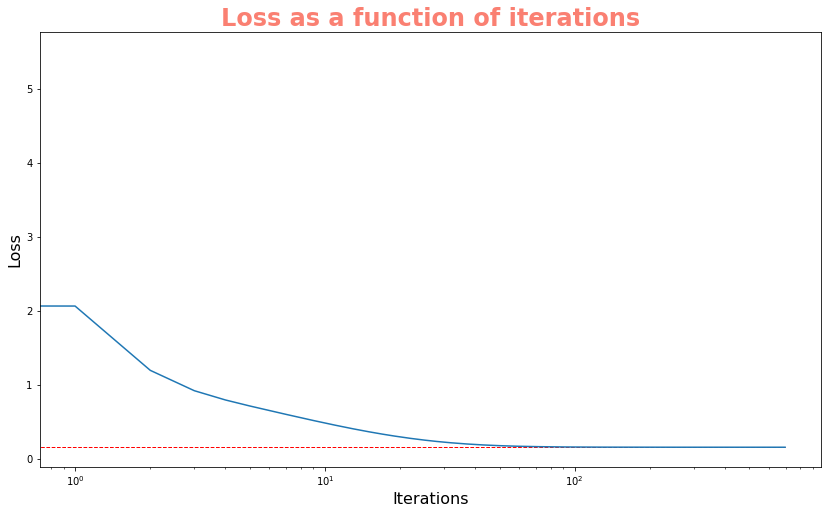

In [101]:
plt.plot(iter, J_history)
plt.xscale('log')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.title('Loss as a function of iterations', fontsize=24, fontweight='bold', color='salmon')
plt.hlines(y = J_pinv, xmin = 0, xmax = len(J_history), color='r',
           linewidth = 1, linestyle = 'dashed')
plt.show()

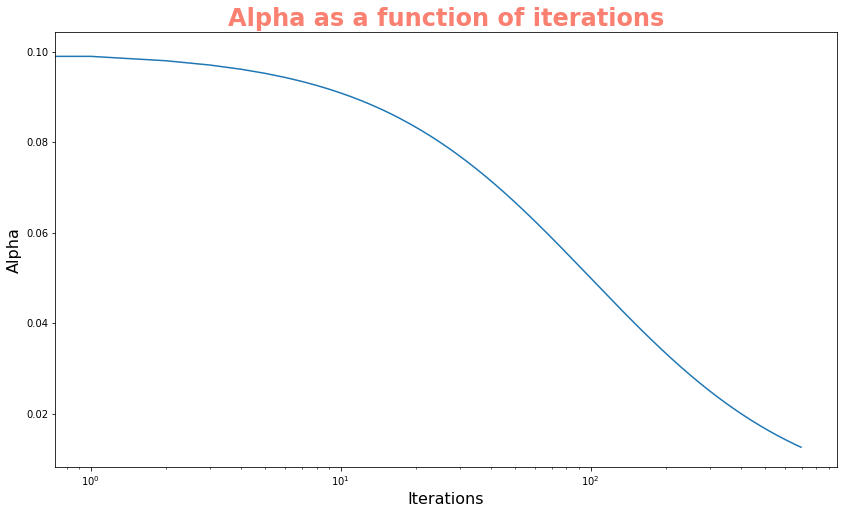

In [102]:
plt.plot(iter, alpha_history)
plt.xscale('log')
plt.xlabel('Iterations', fontsize=16)
plt.ylabel('Alpha', fontsize=16)
plt.title('Alpha as a function of iterations', fontsize=24, fontweight='bold', color='salmon')
plt.show()